# TikTok Claims Classification — 03: EDA Visualizations & Outlier Analysis

***Visual profiling of distributions and outlier detection to inform feature engineering and modeling strategy***

**Author:** Katherine Ygbuhay  
**Updated:** 2025-10-04  
**Stage:** 03 — EDA Visualizations  
**Runtime:** ~25 minutes  

## Objective

Profile distributions, compare groups through visualizations, and quantify outliers to inform downstream feature engineering and modeling for TikTok claims classification.

## Scope & Approach

- **Distribution visualization** of engagement metrics using histograms and boxplots
- **Group comparison analysis** across claim status, verification, and author ban categories
- **Outlier detection** using robust statistical thresholds (median + 1.5×IQR)
- **Relationship exploration** through scatter plots and correlation analysis
- **Accessibility-first visualization** with colorblind-friendly palettes and clear labeling

## Key Outputs

- Comprehensive visual documentation of engagement metric distributions
- Group-level comparison insights showing claim vs. opinion patterns
- Outlier quantification across all engagement variables
- Visual evidence of viral content dynamics and moderation effects
- Recommendations for feature engineering and outlier handling strategies

## Prerequisites

- Cleaned TikTok dataset from data exploration stage
- Understanding of social media engagement patterns and content moderation context
- Familiarity with outlier detection methods for skewed distributions

---

### Imports and Data Loading

In [1]:
# Core libraries for data manipulation
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings for improved readability
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [2]:
# Seaborn theme + accessibility defaults
# - "whitegrid" improves readability
# - "colorblind" is the Okabe–Ito palette (CB-friendly)
sns.set_theme(style="whitegrid", palette="colorblind")

# Consistent figure sizing & typography
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (7, 5)    # default for most plots
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["legend.title_fontsize"] = 11
mpl.rcParams["legend.fontsize"] = 10

# Category palette maps (use everywhere for consistent colors)
claim_palette = {"claim": "#0072B2", "opinion": "#E69F00"}                 # blue / orange
verified_palette = {"verified": "#009E73", "not verified": "#0072B2"}      # green / blue
ban_palette = {"active": "#0072B2", "under review": "#E69F00", "banned": "#D55E00"}  # blue / orange / vermillion

In [3]:
# Resolve the case-study root so paths work from any launch directory
from pathlib import Path

def find_case_root(start: Path | None = None) -> Path:
    p = start or Path.cwd()
    for q in [p, *p.parents]:
        if (q / "notebooks").exists() and (q / "data").exists():
            return q
    return p  # fallback

CASE_ROOT = find_case_root()
DATA_FILE = CASE_ROOT / "data" / "raw" / "tiktok_dataset.csv"
assert DATA_FILE.exists(), f"Missing data file: {DATA_FILE}"

In [4]:
# Load dataset
df = pd.read_csv(DATA_FILE)

In [5]:
# Display the first few records
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.000,19425.000,241.000,1.000,0.000
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.000,77355.000,19034.000,1161.000,684.000
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.000,97690.000,2858.000,833.000,329.000
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.000,239954.000,34812.000,1234.000,584.000
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.000,34987.000,4110.000,547.000,152.000


In [6]:
# Dimensions of the dataset
df.shape

(19382, 12)

In [7]:
# Total number of elements (rows × columns)
df.size

232584

In [8]:
# Data types, non-null counts, and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [9]:
# Extended DataFrame summary with missing value counts and percentages
def df_info_plus(df):
    """
    Extended DataFrame info:
    - Column name and dtype
    - Non-null and missing counts
    - % missing values
    """
    info = []
    for col in df.columns:
        non_null = df[col].notnull().sum()
        nulls = df.shape[0] - non_null
        pct_missing = (nulls / df.shape[0]) * 100
        dtype = df[col].dtype
        info.append([col, dtype, non_null, nulls, f"{pct_missing:.2f}%"])
    
    return pd.DataFrame(
        info,
        columns=["Column", "Dtype", "Non-Null Count", "Missing Count", "% Missing"]
    )

# Display extended info table
df_info_plus(df)

,Column,Dtype,Non-Null Count,Missing Count,% Missing
0,#,int64,19382,0,0.00%
1,claim_status,object,19084,298,1.54%
2,video_id,int64,19382,0,0.00%
3,video_duration_sec,int64,19382,0,0.00%
4,video_transcription_text,object,19084,298,1.54%
5,verified_status,object,19382,0,0.00%
6,author_ban_status,object,19382,0,0.00%
7,video_view_count,float64,19084,298,1.54%
8,video_like_count,float64,19084,298,1.54%
9,video_share_count,float64,19084,298,1.54%


In [10]:
# Descriptive statistics for numeric features
df.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000,19382.000,19382.000,19084.000,19084.000,19084.000,19084.000,19084.000
mean,9691.500,5627454067.339,32.422,254708.559,84304.636,16735.248,1049.430,349.312
std,5595.246,2536440464.169,16.230,322893.281,133420.547,32036.174,2004.300,799.639
min,1.000,1234959018.000,5.000,20.000,0.000,0.000,0.000,0.000
25%,4846.250,3430416807.250,18.000,4942.500,810.750,115.000,7.000,1.000
50%,9691.500,5618663579.000,32.000,9954.500,3403.500,717.000,46.000,9.000
75%,14536.750,7843960211.250,47.000,504327.000,125020.000,18222.000,1156.250,292.000
max,19382.000,9999873075.000,60.000,999817.000,657830.000,256130.000,14994.000,9599.000


### Exploratory Visualizations

Visualize distributions of engagement variables and examine relationships across claim status, verification, and author ban status. These plots help identify skewness, outliers, and group-level differences that may inform feature engineering.

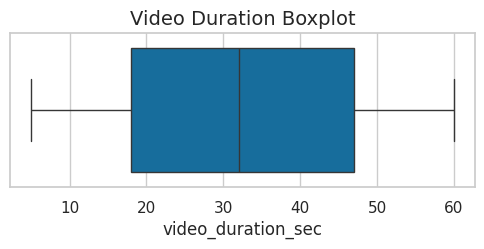

In [11]:
# Boxplot of video duration (seconds)
plt.figure(figsize=(6, 2))
sns.boxplot(x=df['video_duration_sec'])
plt.title('Video Duration Boxplot')
plt.show()

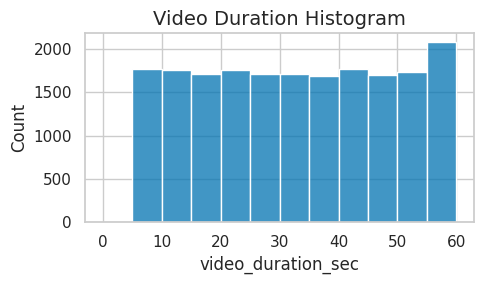

In [12]:
# Histogram of video duration (seconds)
plt.figure(figsize=(5, 3))
sns.histplot(df['video_duration_sec'], bins=range(0, 61, 5))
plt.title('Video Duration Histogram')
plt.tight_layout()
plt.show()

- **Observation — video duration:** Most videos cluster at shorter durations with a long right tail, indicating fewer long-form videos.

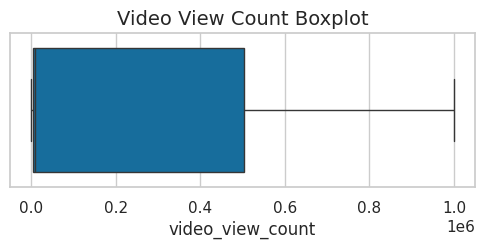

In [13]:
# Boxplot of video view count
plt.figure(figsize=(6, 2))
sns.boxplot(x=df['video_view_count'])
plt.title('Video View Count Boxplot')
plt.show()

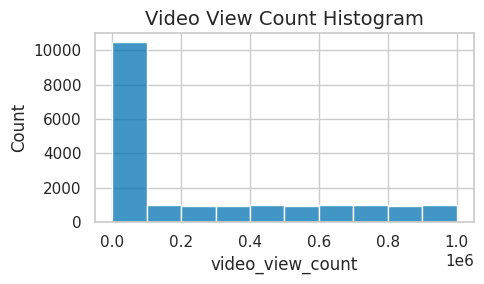

In [14]:
# Histogram of video view count
plt.figure(figsize=(5, 3))
sns.histplot(df['video_view_count'], bins=range(0, (10**6 + 1), 10**5))
plt.title('Video View Count Histogram')
plt.tight_layout()
plt.show()

- **Observation — view count:** More than half of videos receive under 100K views; the distribution is heavily right-skewed with a small subset of high-view outliers.

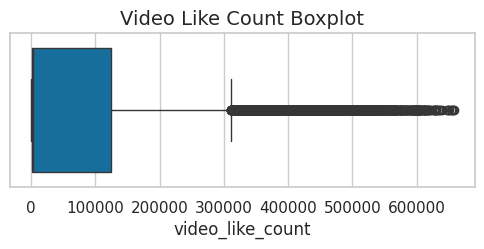

In [15]:
# Boxplot of video like count
plt.figure(figsize=(6, 2))
sns.boxplot(x=df['video_like_count'])
plt.title('Video Like Count Boxplot')
plt.show()

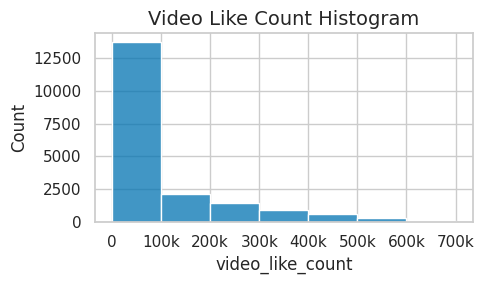

In [16]:
# Histogram of video like count
plt.figure(figsize=(5, 3))
ax = sns.histplot(df['video_like_count'], bins=range(0, 7*10**5 + 1, 10**5))
ax.set_xticks(range(0, 7*10**5 + 1, 10**5))
ax.set_xticklabels([0] + [f'{i}k' for i in range(100, 701, 100)])
plt.title('Video Like Count Histogram')
plt.tight_layout()
plt.show()

- **Observation — like count:** The majority of videos have <100K likes; distribution tapers with a long right tail, reflecting a small set of highly liked videos.

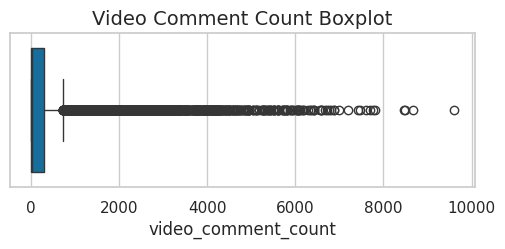

In [17]:
# Boxplot of video comment count
plt.figure(figsize=(6, 2))
sns.boxplot(x=df['video_comment_count'])
plt.title('Video Comment Count Boxplot')
plt.show()

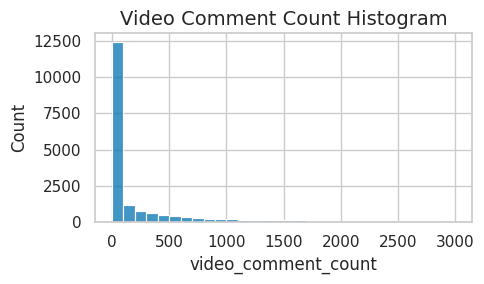

In [18]:
# Histogram of video comment count
plt.figure(figsize=(5, 3))
sns.histplot(df['video_comment_count'], bins=range(0, 3001, 100))
plt.title('Video Comment Count Histogram')
plt.tight_layout()
plt.show()

- **Observation — comment count:** Most videos have fewer than 100 comments; the distribution is highly right-skewed with sparse high-comment outliers.

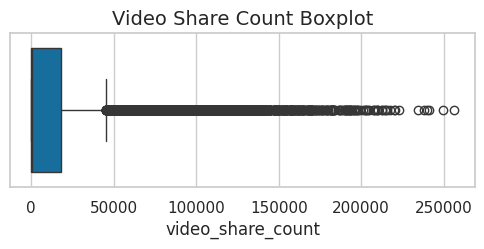

In [19]:
# Boxplot of video share count
plt.figure(figsize=(6, 2))
sns.boxplot(x=df['video_share_count'])
plt.title('Video Share Count Boxplot')
plt.show()

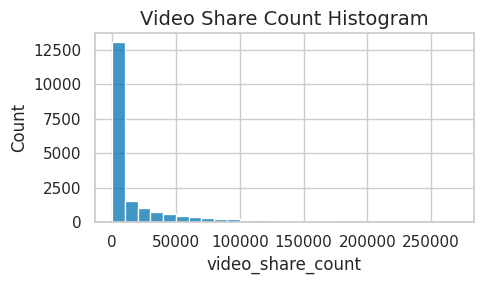

In [20]:
# Histogram of video share count
plt.figure(figsize=(5, 3))
sns.histplot(df['video_share_count'], bins=range(0, 270001, 10000))
plt.title('Video Share Count Histogram')
plt.tight_layout()
plt.show()

- **Observation — share count:** The overwhelming majority of videos have fewer than 10,000 shares; the distribution is strongly right-skewed.

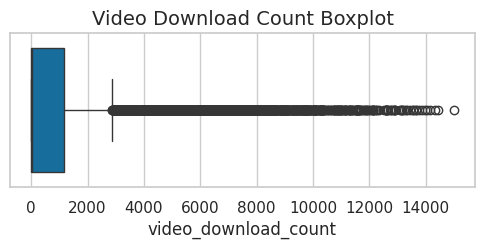

In [21]:
# Boxplot of video download count
plt.figure(figsize=(6, 2))
sns.boxplot(x=df['video_download_count'])
plt.title('Video Download Count Boxplot')
plt.show()

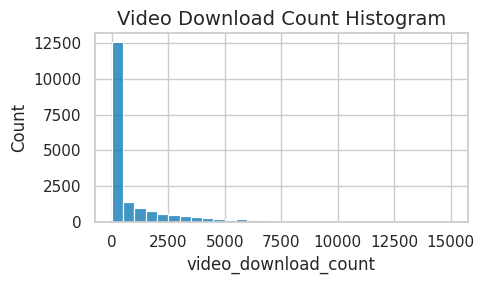

In [22]:
# Histogram of video download count
plt.figure(figsize=(5, 3))
sns.histplot(df['video_download_count'], bins=range(0, 15001, 500))
plt.title('Video Download Count Histogram')
plt.tight_layout()
plt.show()

- **Observation — download count:** Most videos are downloaded fewer than 500 times, with a long tail extending beyond 12,000 downloads.

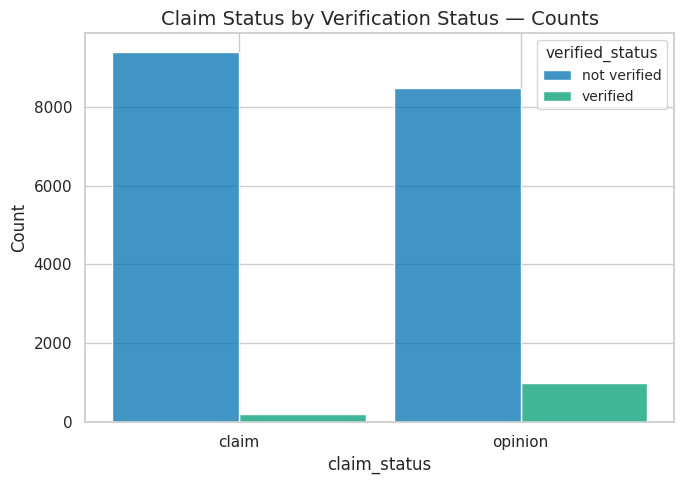

In [23]:
# Claims by verification status (count histogram)
plt.figure(figsize=(7, 5))
sns.histplot(
    data=df,
    x="claim_status",
    hue="verified_status",
    multiple="dodge",
    shrink=0.9,
    palette=verified_palette
)
plt.title("Claim Status by Verification Status — Counts")
plt.tight_layout()
plt.show()

- **Observation — verification:** Verified users are fewer overall; conditional on verification, opinion posts appear relatively more common than claims.

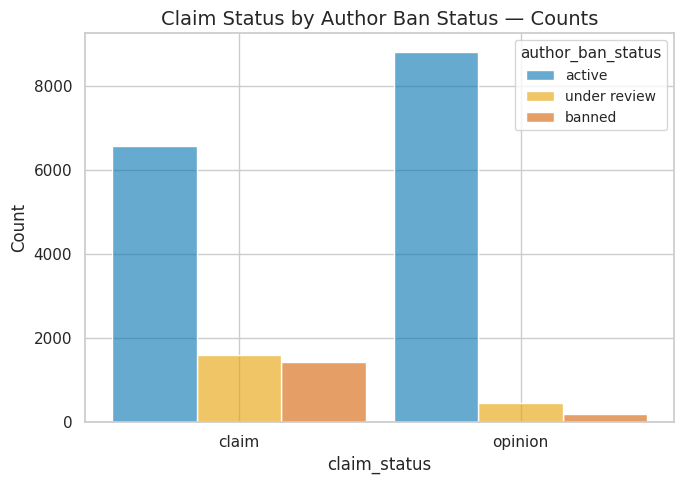

In [24]:
# Claim status by author ban status (count histogram)
plt.figure(figsize=(7, 5))
sns.histplot(
    data=df,
    x="claim_status",
    hue="author_ban_status",
    multiple="dodge",
    hue_order=["active", "under review", "banned"],
    shrink=0.9,
    palette=ban_palette,
    alpha=0.6
)
plt.title("Claim Status by Author Ban Status — Counts")
plt.tight_layout()
plt.show()

- **Observation — moderation state:** Active authors dominate overall counts; however, claims are relatively more prevalent among under-review/banned authors than among active authors.

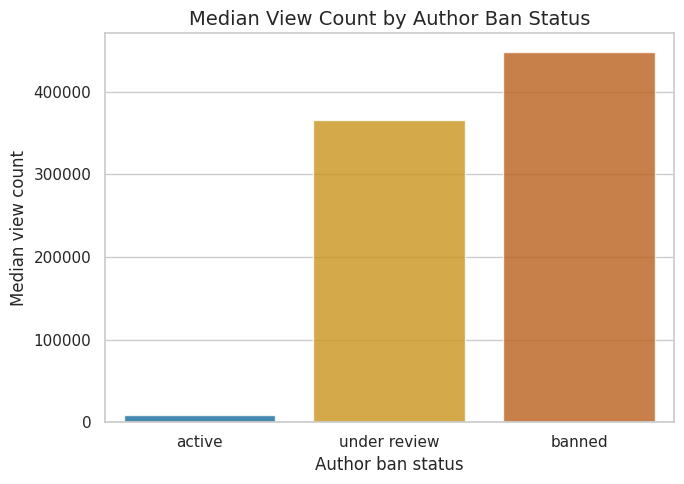

In [25]:
# Median view count by author ban status (bar plot)
ban_status_medians = (
    df.groupby("author_ban_status")
      .median(numeric_only=True)
      .reset_index()
)

plt.figure(figsize=(7, 5))
sns.barplot(
    data=ban_status_medians,
    x="author_ban_status",
    y="video_view_count",
    hue="author_ban_status",          # fixes Seaborn ≥0.14 palette warning
    legend=False,
    order=["active", "under review", "banned"],
    palette=ban_palette,
    alpha=0.8
)
plt.title("Median View Count by Author Ban Status")
plt.xlabel("Author ban status")
plt.ylabel("Median view count")
plt.tight_layout()
plt.show()

- **Observation — median views by moderation state:** Median views for under-review/banned authors exceed those for active authors, suggesting distinct exposure/virality dynamics.

In [26]:
# Median view count by claim status (table output)
df.groupby('claim_status')['video_view_count'].median()

claim_status
claim     501555.000
opinion     4953.000
Name: video_view_count, dtype: float64

- **Observation — median views by claim status:** Median view counts are higher for claim videos than for opinion videos, reinforcing the earlier engagement trend.

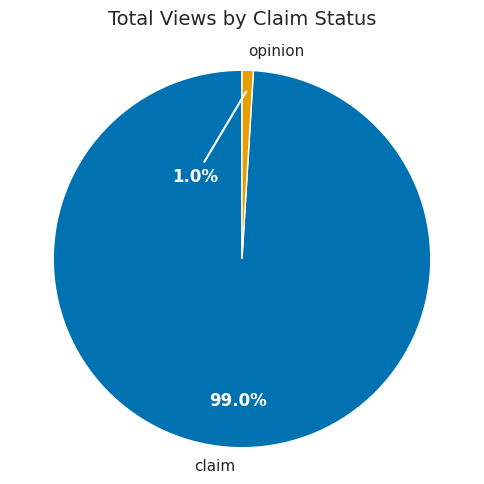

In [27]:
import matplotlib.pyplot as plt

# Sum total views by claim status
totals = (
    df.groupby("claim_status")["video_view_count"]
      .sum(min_count=1)
      .reindex(["claim", "opinion"])
      .fillna(0.0)
      .astype(float)
)

# Calculate the opinion percentage for annotation
opinion_pct = totals.loc["opinion"] / totals.sum() * 100

fig, ax = plt.subplots(figsize=(5, 5))
wedges, texts, autotexts = ax.pie(
    totals.values,
    labels=totals.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#0072B2', '#E69F00'],
    labeldistance=1.1,
    pctdistance=0.75
)

# Style percentage labels
for t in autotexts:
    t.set_fontsize(12)
    t.set_color("white")
    t.set_weight("bold")

# Remove the cramped % for the opinion wedge
autotexts[1].set_text("")

# Add your clean inside annotation line back
ax.annotate(
    f"{opinion_pct:.1f}%",
    xy=(0.03, 0.9),        # where the line points
    xytext=(0.4, 0.7),     # where the label sits
    textcoords='axes fraction',
    arrowprops=dict(arrowstyle="-", color="white", lw=1.5),
    ha='center', va='center', fontsize=12, weight='bold', color='white'
)

ax.set_title("Total Views by Claim Status", pad=20)
ax.axis('equal')
plt.tight_layout()
plt.show()

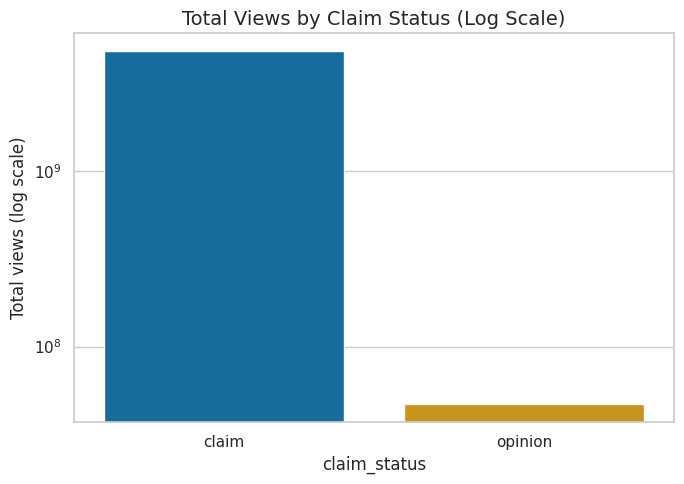

In [28]:
# Total views by claim status (log scale, color-blind friendly)
totals = (
    df.groupby("claim_status")["video_view_count"]
      .sum()
      .sort_values(ascending=False)
)

plt.figure(figsize=(7, 5))
sns.barplot(
    x=totals.index,
    y=totals.values,
    hue=totals.index,      # silences palette warning
    legend=False,
    palette=[claim_palette[c] for c in totals.index]
)
plt.title("Total Views by Claim Status (Log Scale)")
plt.ylabel("Total views (log scale)")
plt.yscale("log")
plt.tight_layout()
plt.show()

- **Observation — total views share:** Despite similar class counts, claim videos account for the overwhelming majority of total views. Both the pie chart and bar chart confirm this imbalance.

### Outlier Detection

Outliers are defined as values exceeding:  
**Threshold = median + 1.5 × IQR**  
for each count variable. This provides a skew-robust measure of unusually high engagement values.

In [29]:
# Count variables to check for outliers
count_cols = [
    'video_view_count',
    'video_like_count',
    'video_share_count',
    'video_download_count',
    'video_comment_count'
]

# Calculate outlier counts per variable
for column in count_cols:
    q1, q3 = df[column].quantile([0.25, 0.75])
    iqr = q3 - q1
    median = df[column].median()
    threshold = median + 1.5 * iqr
    out_count = (df[column] > threshold).sum()
    pct = 100 * out_count / len(df)
    print(f"Outliers in {column}: {out_count} ({pct:.1f}%)  [threshold={threshold:,.0f}]")

Outliers in video_view_count: 2343 (12.1%)  [threshold=759,031]
Outliers in video_like_count: 3468 (17.9%)  [threshold=189,717]
Outliers in video_share_count: 3732 (19.3%)  [threshold=27,878]
Outliers in video_download_count: 3733 (19.3%)  [threshold=1,770]
Outliers in video_comment_count: 3882 (20.0%)  [threshold=446]


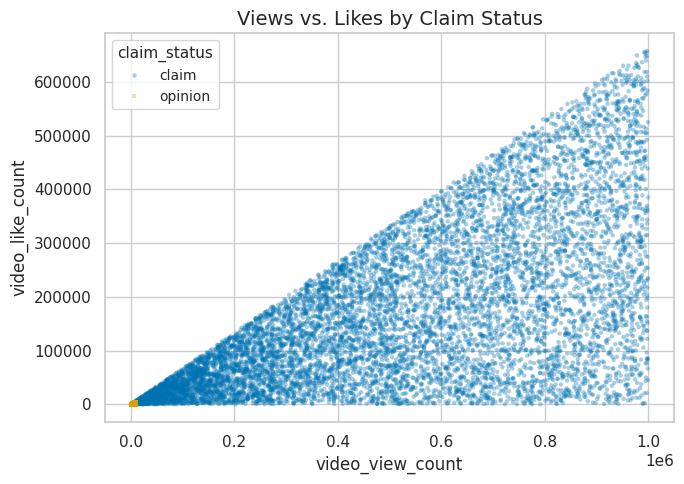

In [30]:
# Views vs. Likes by Claim Status
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df,
    x="video_view_count",
    y="video_like_count",
    hue="claim_status",
    style="claim_status",
    markers={"claim": "o", "opinion": "s"},
    palette=claim_palette,
    s=10, alpha=0.35, edgecolor="none"
)
plt.title("Views vs. Likes by Claim Status")
plt.tight_layout()
plt.show()

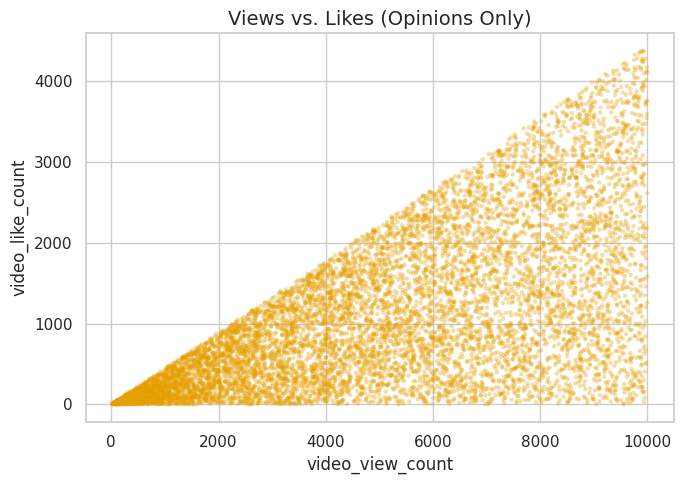

In [31]:
# Views vs. Likes (Opinions Only)
opinion = df[df["claim_status"] == "opinion"]

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=opinion,
    x="video_view_count",
    y="video_like_count",
    color=claim_palette["opinion"],
    s=10, alpha=0.35, edgecolor="none"
)
plt.title("Views vs. Likes (Opinions Only)")
plt.tight_layout()
plt.show()

### Conclusion

This exploratory analysis established a detailed understanding of the TikTok dataset. Key steps included reviewing variable distributions, quantifying missing values, detecting outliers, and examining relationships across claim status, verification, and author ban status. Several consistent patterns emerged:

- **Balanced labels:** Claims and opinions are present in nearly equal proportions, supporting supervised modeling.  
- **Engagement skew:** All engagement variables are heavily right-skewed, with a small number of viral videos driving much of the variance.  
- **Claim dynamics:** Claim videos receive higher views, likes, and shares than opinion videos.  
- **Moderation effects:** Authors flagged as banned or under review tend to generate higher engagement, though this correlation does not imply causality.  
- **Outliers:** Viral outliers are a natural feature of social media data; they will need to be considered explicitly during feature engineering and modeling.

Visualizations created in this notebook, and extended in Tableau, provided complementary perspectives on these patterns and reinforced the same conclusions.

**Next steps:**  
- Engineer features that capture engagement patterns, author moderation status, and claim/opinion balance.  
- Address skewness and outliers (e.g., transformations or robust metrics).  
- Evaluate which variables provide the strongest predictive signal for claim status.  